---
title: Extending to 3D
subtitle: NIGnets for Representing Non-Self-Intersecting 3D Geometry.
date: 2025-03-06
---

The framework we have developed till now and tested on 2D curves can be seamlessly extended to 3D.
We now look at how to do this and then test the framework by fitting shapes.

In [1]:
# Basic imports
import torch
from torch import nn
import geosimilarity as gs
from NIGnets import NIGnet

from assets.utils import automate_training, plot_surfaces

device = 'mps' if torch.backends.mps.is_available() else 'cpu'

# Modifying Injective Networks

The only change we need to do in the entire framework is only in the Injective Network. In
particular, we need to make the following two changes:

Simple Surfaces: Injectivity
: The output instead of being a vector $[x, y]^{T}$ for curves now has to be $[x, y, z]^{T}$ for
    surfaces. This means that the network width instead of being constrained to 2 hidden neurons,
    now has to be 3 hidden neurons.

Closed Condition
: For tracing out curves in 2D we required a single parameter $t \in [0, 1]$ and the interval
    $[0, 1]$ was transformed to the unit circle by the initial transformation:
    :::{math}
    C(t) = 
    \begin{bmatrix}
    cos(2\pi t)\\
    sin(2\pi t)
    \end{bmatrix}
    :::
    For tracing out surfaces in 3D we need two parameters as a surface in 3D is a 2 dimensional object.
    Therefore we use parameters $t, s \in [0, 1] \times [0, 1]$. This corresponds to the unit square in
    the 2D plane. The closed transformation requires us to transform this to the unit sphere as follows:
    :::{math}
    C(t) = 
    \begin{bmatrix}
    sin(\pi s) cos(2 \pi t)\\
    sin(\pi s) sin(2 \pi t)\\
    cos(\pi s)
    \end{bmatrix}
    :::

These changes lead to the Injective Network architecture shown in
[](#injective_network_architecture_3D).
:::{figure} assets/injective_network_architecture_3D.svg
:label: injective_network_architecture_3D
:alt: Figure showing the injective network architecture that produces simple closed surfaces in 3D.
:height: 300px
Modified Injective Network architecture that produces simple closed surfaces in 3D. This is an
extension of the architecture we developed for producing simple closed curves in 2D.
:::

## Fitting Surfaces
We now fit the 3D Injective Network to target surfaces. In 2D the points on a curve had an ordering
and we could compare corresponding points on the target curve and the candidate curve represented
by our NIGnet using a Mean Squared Error (MSE) loss. In 3D there is no ordering of points on the
target and the candidate surfaces and hence we cannot use the MSE loss function. Instead we use the
[ChamferLoss](https://github.com/atharvaaalok/geosimilarity/blob/main/geosimilarity/chamfer.py) from
the geometric loss function package [geosimilarity](https://github.com/atharvaaalok/geosimilarity).
The Chamfer Distance measures the distance between two specified point clouds.

Epoch: [   1/1000]. Loss:    1.353329
Epoch: [ 200/1000]. Loss:    0.001079
Epoch: [ 400/1000]. Loss:    0.000685
Epoch: [ 600/1000]. Loss:    0.000626
Epoch: [ 800/1000]. Loss:    0.000590
Epoch: [1000/1000]. Loss:    0.000589


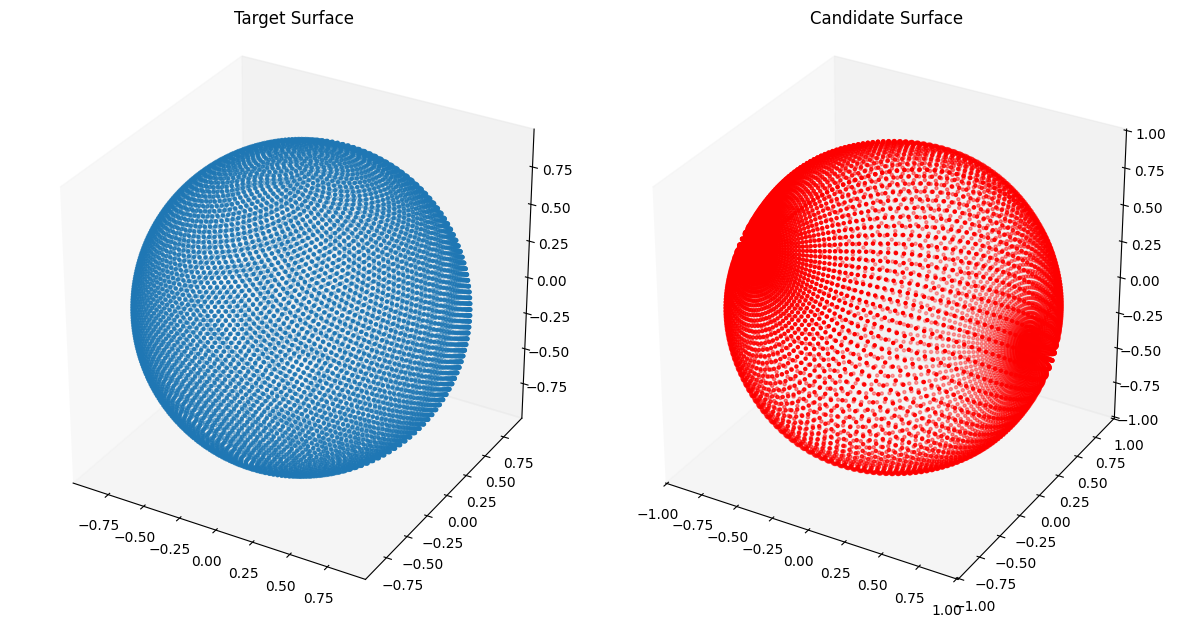

In [16]:
from assets.shapes import sphere

# Generate target curve points
num_pts = 100
t, s = torch.meshgrid(torch.linspace(0, 1, num_pts), torch.linspace(0, 1, num_pts),
                      indexing = 'ij')
T = torch.stack([t, s], dim = -1).reshape(-1, 2).to(device)
Xt = sphere(num_pts * num_pts).to(device)

# Create NIGnet to fit the target
nig_net = NIGnet(layer_count = 3, act_fn = nn.Tanh, geometry_dim = 3,
                 skip_connections = False).to(device)

automate_training(
    model = nig_net, loss_fn = gs.ChamferLoss(), X_train = T, Y_train = Xt,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

# Plot the candidate and the target geometries
Xc = nig_net(T)
plot_surfaces(Xc, Xt)

Epoch: [   1/1000]. Loss:    2.058981
Epoch: [ 200/1000]. Loss:    0.004339
Epoch: [ 400/1000]. Loss:    0.003087
Epoch: [ 600/1000]. Loss:    0.002064
Epoch: [ 800/1000]. Loss:    0.001898
Epoch: [1000/1000]. Loss:    0.001840


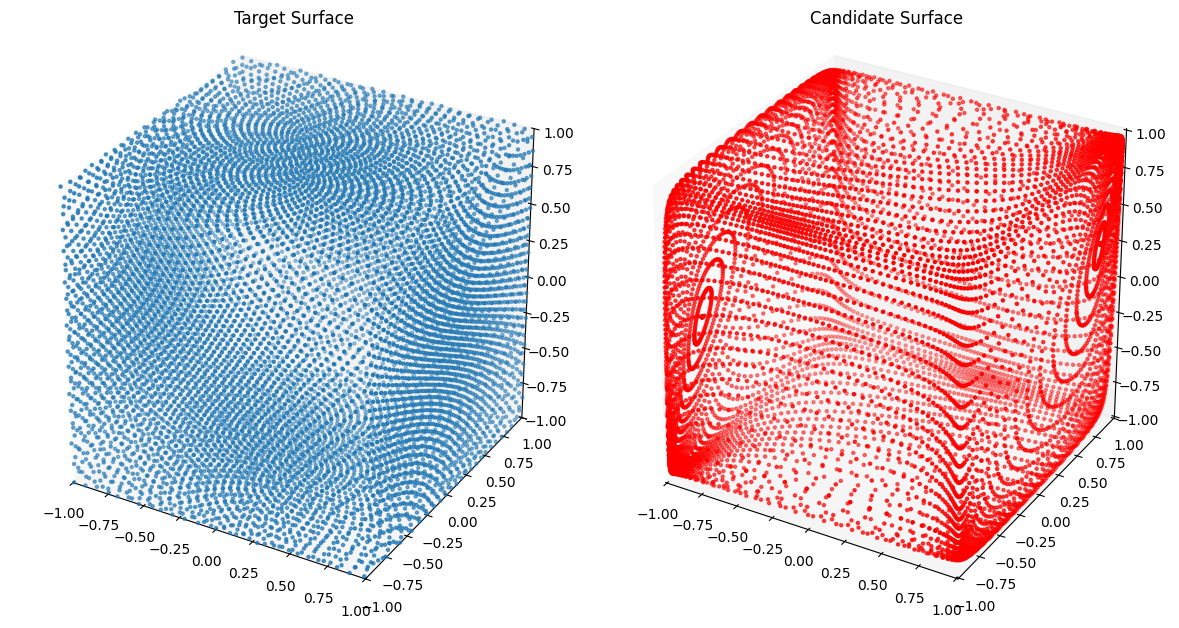

In [17]:
from assets.shapes import cube

# Generate target curve points
num_pts = 100
t, s = torch.meshgrid(torch.linspace(0, 1, num_pts), torch.linspace(0, 1, num_pts),
                      indexing = 'ij')
T = torch.stack([t, s], dim = -1).reshape(-1, 2).to(device)
Xt = cube(num_pts * num_pts).to(device)

# Create NIGnet to fit the target
nig_net = NIGnet(layer_count = 3, act_fn = nn.Tanh, geometry_dim = 3,
                 skip_connections = False).to(device)

automate_training(
    model = nig_net, loss_fn = gs.ChamferLoss(), X_train = T, Y_train = Xt,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

# Plot the candidate and the target geometries
Xc = nig_net(T)
plot_surfaces(Xc, Xt)

Awesome! We see that we are doing good on simple shapes as we did in 2D.

Now we move onto fitting the Stanford Bunny.

Epoch: [   1/1000]. Loss:    0.700528
Epoch: [ 200/1000]. Loss:    0.010103
Epoch: [ 400/1000]. Loss:    0.008260
Epoch: [ 600/1000]. Loss:    0.008171
Epoch: [ 800/1000]. Loss:    0.007735
Epoch: [1000/1000]. Loss:    0.007970


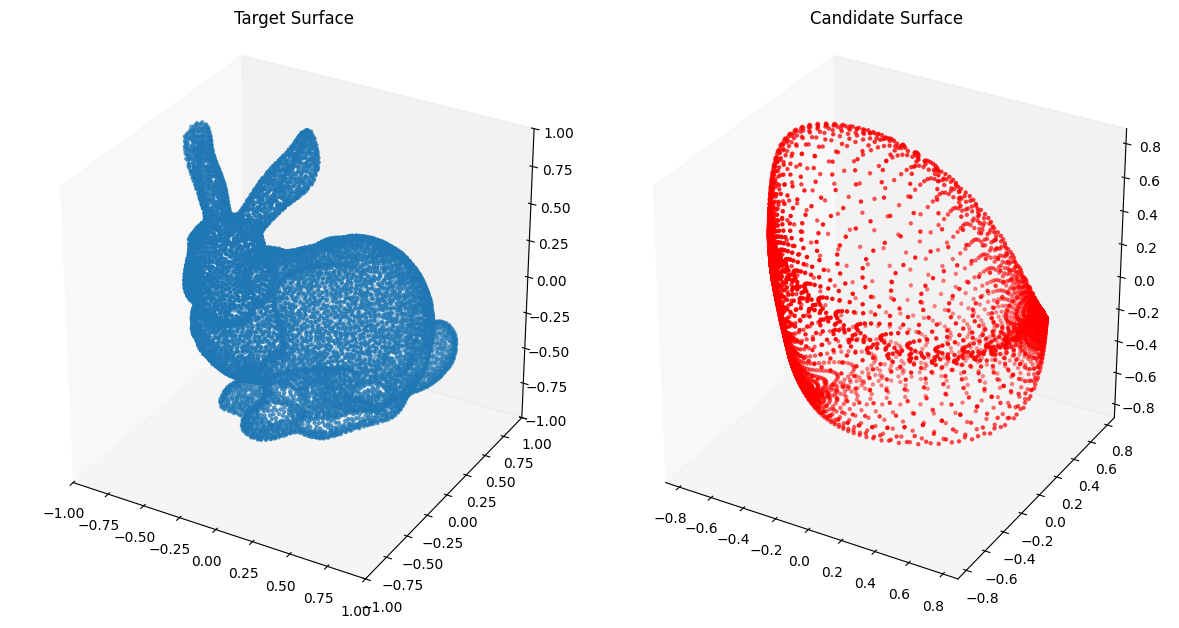

In [20]:
from assets.shapes import stanford_bunny_3d

# Generate target curve points
num_pts = 100
t, s = torch.meshgrid(torch.linspace(0, 1, num_pts), torch.linspace(0, 1, num_pts),
                      indexing = 'ij')
T = torch.stack([t, s], dim = -1).reshape(-1, 2).to(device)
Xt = stanford_bunny_3d(num_pts * num_pts).to(device)

# Create NIGnet to fit the target
nig_net = NIGnet(layer_count = 3, act_fn = nn.Tanh, geometry_dim = 3,
                 skip_connections = False).to(device)

automate_training(
    model = nig_net, loss_fn = gs.ChamferLoss(), X_train = T, Y_train = Xt,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

# Plot the candidate and the target geometries
Xc = nig_net(T)
plot_surfaces(Xc, Xt)

We observe very poor performance❗⚠️

We now move on to using Monotonic Networks and PreAux Nets to power 3D Injective Networks. As with
the 3D Injective Networks the first transformation for the PreAux Net will also be the closed
transformation to the unit sphere.